# **Mô tả bài toán**
**Quora** là một nền tảng cho phép mọi người học hỏi lẫn nhau. Trên **Quora**, mọi người có thể đặt câu hỏi và kết nối với những người khác, những người đóng góp thông tin chi tiết độc đáo và câu trả lời chất lượng. Một thách thức quan trọng là loại bỏ những câu hỏi thiếu chân thành - những câu hỏi được đặt ra dựa trên những tiền đề sai lầm hoặc có ý định đưa ra một tuyên bố hơn là tìm kiếm những câu trả lời hữu ích.

**Quora Insincere Question Classification** là một bài toán của **Quora** đặt ra, sử dụng sự trợ giúp từ cộng đồng, giúp họ phân loại những câu hỏi không chân thành, đi ngược lại với chính sách của họ là _"Be Nice, Be Respecfull"_

Nhiệm vụ của bài toán là sử dụng tập dữ liệu mà **Quora** cung cấp để phân loại đâu là những câu hỏi mang hàm ý không chân thành, mang nội dung xấu độc, gây hiểu lầm.

- **Input**: Câu hỏi dưới dạng văn bản (plain text)
- **Output**: Yes/No

# **Nội Dung Bài Báo Cáo**
#### 1. Khảo sát dữ liệu
#### 2. Tiền Xử Lý Dữ Liệu
#### 3. Build tập Vocab
#### 4. Chuẩn bị Model
#### 5. Huấn luyện và Dự đoán
#### 6. So sánh. mở rộng

# **Hướng Tiếp Cận**
- Tiền xử lý bộ dữ liệu
    - Bỏ đi các biểu thức toán học và các đường dẫn liên kết
    - Bỏ đi các ký tự đặc biệt, các chữ số
    - Sửa những từ sai chính tả và extend các từ viết tắt
    - Bỏ đi stop_words trong câu
    - Lemming các từ có trong câu (có thể hiểu là chuyển các từ về dạng nguyên thể)
    
> **Mục đích**: Loại bỏ đi các từ gây nhiễu cho bộ dữ liệu và mở rộng độ bao phủ của tập Vocab với bộ dữ liệu
- Xây dựng tập vocab: 
    - Sử dụng file embeddings.zip mà quora cung cấp để xây dựng tập vocab những từ trong các câu được đánh là insincere (Cụ thể là file GoogleNews)
    - Các file embeddings có dạng text, mỗi dòng chứa 1 word và đi kèm đó là vector của nó đã được pretrained
    - Xây tập vocab từ các word có trong từ điển và vector đi kèm với chúng
    - Kiểm tra độ phủ của vocab xây dựng dựa trên tập embeddings với dữ liệu được cho


# **1. Khảo sát dữ liệu**

In [1]:
import pandas as pd 
import seaborn as sns
import re
import gc
import os
import numpy as np
import operator
from wordcloud import WordCloud, STOPWORDS
from tqdm import tqdm
import matplotlib.pyplot as plt
pd_ctx = pd.option_context('display.max_colwidth', 100)

import nltk
from nltk.stem import PorterStemmer, SnowballStemmer, WordNetLemmatizer

from gensim.models import KeyedVectors

import tensorflow as tf

from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D,GRU
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model,load_model
from keras.utils import plot_model
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences

Xác định các tập ```train```, ```test``` và khởi tạo một tập chứa dữ liệu của cả 2 để về sau check độ bao phủ của vocab với tập dữ liệu đã sinh

In [2]:
df_train = pd.read_csv('/kaggle/input/quora-insincere-questions-classification/train.csv')
df_test = pd.read_csv('/kaggle/input/quora-insincere-questions-classification/test.csv')
quora_data = df_train['question_text'].append(df_test['question_text'])

### **a. Khảo sát dữ liệu trong tập **train****

In [3]:
print("\033[1mTrain set info\033[0m")
print(df_train.info())

Train set info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1306122 entries, 0 to 1306121
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   qid            1306122 non-null  object
 1   question_text  1306122 non-null  object
 2   target         1306122 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 29.9+ MB
None


Ở trong bộ dữ liệu có 3 trường, và khả năng dữ liệu train nằm ở trường **```question_text```** <br>
Vậy ta sẽ thử khảo sát dữ liệu trong trường **```question_text```**

In [4]:
# Kiểm tra các trường dữ liệu của câu hỏi được đánh sincere
print("\033[1mSincere Questions: \033[0m")
display(df_train[df_train['target']==0].head())
# Kiểm tra các trường dữ liệu của câu hỏi được đánh sincere
print("\033[1mInsincere Questions: \033[0m")
display(df_train[df_train['target']==1].head())

Sincere Questions: 


,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


Insincere Questions: 


,qid,question_text,target
22,0000e91571b60c2fb487,Has the United States become the largest dicta...,1
30,00013ceca3f624b09f42,Which babies are more sweeter to their parents...,1
110,0004a7fcb2bf73076489,If blacks support school choice and mandatory ...,1
114,00052793eaa287aff1e1,I am gay boy and I love my cousin (boy). He is...,1
115,000537213b01fd77b58a,Which races have the smallest penis?,1


Có thể thấy rằng tập train có 3 trường dữ liệu
- **```qid```**: định danh id cho câu hỏi
- **```question_text```**: nội dung câu hỏi
- **```target```**: phân lớp câu hỏi
    - 0: câu hỏi mang tính chất chân thành (sincere)
    - 1: câu hỏi không mang tính chất chân thành (insincere)
    
Khá may mắn khi tập dữ liệu **Quora** cung cấp không có bất kì trường dữ liệu nào có giá trị bất thường (```null```, ```none```, ```missing```)
    
Tập dữ liệu train bao gồm **1306122** dòng dữ liệu, gần **1.31 triệu dòng**, khá lớn. Cần sử dụng mô hình có hiệu quả tính toán nhanh, nên trong bài này em sẽ không sử dụng mô hình với thuật toán ensemble

Theo dự đoán thì trường **```target```** sẽ là đánh dấu các câu hỏi sincere và insincere nên cần xem thử là trong trường **```target```** đó có những giá trị gì

In [5]:
df_train.target.value_counts()

0    1225312
1      80810
Name: target, dtype: int64

Có thể thấy trong trường target có 2 giá trị là ```0``` và ```1```<br>
Dự đoán thì những câu hỏi đánh dấu ```0``` là những câu hỏi sincere, tương tự ```1``` là insincere<br>
Vậy có thể xem như đây là bài toán phân lớp nhị phân<br>
Nhưng vẫn cần phải có đánh giá sâu hơn về bộ dữ liệu này, nhìn nhanh qua có thể thấy bộ dữ liệu train được cho khá là mất cân bằng

Total =  1306122
Sincere questions: 1225312 ( 93.81% )
Insincere questions: 80810 ( 6.19% )


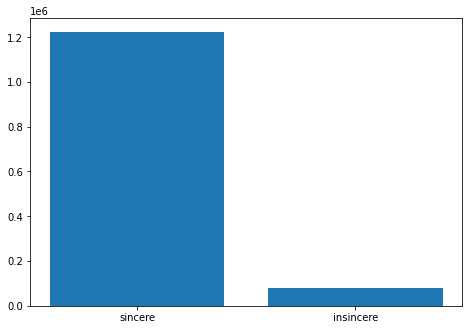

In [6]:
pos_len = len(df_train[df_train['target'] == 1])
neg_len = len(df_train[df_train['target'] == 0])
total = len(df_train)
print("\033[1mTotal = \033[0m", total)
print("\033[1mSincere questions:\033[0m {neg} ({percent: .2f}% )".format(neg = neg_len, percent = neg_len / total * 100))
print("\033[1mInsincere questions:\033[0m {pos} ({percent: .2f}% )".format(pos = pos_len, percent = pos_len / total * 100))
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(['sincere', 'insincere'], df_train.target.value_counts())
plt.show()

Qua biểu đồ có thể dễ dàng nhận thấy tập dữ liệu train bị mất cân bằng nhiều:
- Lớp câu hỏi sincere có **1225312** (chiếm **93.81%**) số lượng dữ liệu
- Lớp câu hỏi insincere có **80810** (chiếm **6.19%**) số lượng dữ liệu

Có thể thấy tập dữ liệu bị lệch nhiều (lên tới **15 lần**) cho nên cần phải sử dụng metrics f1_score để đánh giá độ hiệu quả của mô hình hơn là so **accuracy**<br>
Do **f1_score** quan tâm đến phân bố của dữ liệu nên trong bài này nó sẽ mang nhiều ý nghĩa hơn là **accuracy**.<br>
Và trong cuộc thi **Kaggle** cũng bảo là sử dụng **f1_score** thay vì **accuracy**

Tìm hiểu thêm về **[F1 Score](https://en.wikipedia.org/wiki/F-score)**<br>
F1 score là sự **harmonic mean** của **Precision** và **Recall**. F1 Score nhận giá trị trong khoảng ```0``` - ```1```<br>
$$Precision = \frac{TP}{TP+FP}$$
$$Recall = \frac{TP}{TP+FN}$$
$$F1 = \frac{2}{Recall^{-1} + Precision^{-1}}$$

**Nhận xét:**<br>
Có thể coi đây là bài toán phân loại nhị phân. Thường thì ta sẽ nghĩ đến các mô hình tuyến tính như **Logistic Regression** hay **SVM** để phân loại. Nhưng đây là bài toán thiên về tiền xử lý do đầu vào là chuỗi các text, nên quan trọng là việc mình xử lý chuỗi như thế nào. Trong bài này em sẽ sử dụng thằng **Keras** với **LSTM Model** và **Embedings** các chuỗi text để giảm chiều dữ liệu

### **b. Khảo sát dữ liệu trong tập **test**** 

In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375806 entries, 0 to 375805
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   qid            375806 non-null  object
 1   question_text  375806 non-null  object
dtypes: object(2)
memory usage: 5.7+ MB


Ở trong bộ dữ liệu test thì chỉ có 2 trường dữ liệu là **```qid```** đại diện cho id của câu hỏi<br>
Và **```question_text```** đại diện cho dữ liệu test<br>
Cũng may mắn khi mà ở trong tập **df_test** lại không có dữ liệu kì lạ nào cả (```null```, ```none```, ```missing```)<br>
Và cái ta cần quan tâm ở đây chỉ là trường dữ liệu **```question_text```** để đưa vào model

**Reference**: https://stackoverflow.com/questions/29576430/shuffle-dataframe-rows

In [8]:
# Shuffle tập train để kiểm tra những giá trị ngẫu nhiên
train = df_train.sample(frac=1).reset_index(drop=True)
display(train.sample(n=10, random_state=344))

,qid,question_text,target
708921,01f8c6d45d9569603f8c,How are installments calculated in Flipkart?,0
363060,ef89a5386321712cc9d1,What you will do if you miss a person you love...,0
184397,24b0ad9f10620190f860,What are some tips that can help making a Pear...,0
667824,22c1bf80d30aaa2492bd,Has your psychologist ever said inappropriate ...,0
85808,49a5c7cf65a62ebd4f79,What are some great sex positions that my girl...,0
207405,dae99ec74c7558c31b94,How can I make my thinking innovative?,0
1073817,1f912461d772aac96884,Why should I prefer resonance test series over...,0
1209086,960a8df4c7c0526dabd9,Is it safe for a single female to move to Thai...,0
667058,3dfb31eb1f8a78a5e40b,What do some food critics say about Buca di Be...,0
375928,711775fd296269e01885,Does Tinder own 000-003-2099 and use this as t...,0


Mỗi lần shuffle lại cho ra một kết quả khác, nhưng nhìn chung qua vài lần thực nghiệm quan sát, em nhận thấy trong tập dữ liệu ở trên:
- Có nhiều câu mà các từ trong đó viết sai chính tả, lẫn lộn giữa tiếng Anh-Anh và tiếng Anh-Mỹ
- Nhiều câu sử dụng các từ viết tắt: He's mà đáng nhẽ nên là He is.
- Có một số từ viết tắt cho tên các tổ chức, hay các chuẩn mã hoá kiểu RSA, DES/3DES, ...
- Nhiều câu sử dụng các ký tự đặc biệt cho nên sẽ gây ảnh hưởng lớn tới mô hình dự đoán

Về mặt nội dung hàm ý thì có thể không ảnh hưởng nhưng sẽ ảnh hưởng khi xâp tập từ điển, cùng một ý nghĩa nhưng các từ lại được tính nhiều lần giá trị

> **Có thể thấy rằng, bộ dữ liệu đã cho có khá nhiều nhiễu. Việc ta cần phải làm là loại bỏ nhiều nhiều nhất có thể**

**Cách xử lý**
- Loại bỏ stopwords có trong câu
- Stem các từ có trong câu (driver, driving, driven, drove -> drive)
- Chuẩn hoá các từ về lạng lowercase
- Loại bỏ các ký tự đặc biệt
- Loại bỏ các đường dẫn liên kết, loại bỏ các công thức toán học, ...

### **c. Nhận xét**
Nhưng có thể thấy một điều là bộ dữ liệu **train** và **test** dữ liệu đầu vào đều ở dạng plain text và mô hình của chúng ta sẽ không thể hiểu nổi<br>
Vậy hướng giải quyết ở đây em nghĩ là là sử dụng mã hoá **one_hot** đưa dữ liệu về dạng binary để cho mô hình có thể hiểu được

# **2. Tiền xử lý dữ liệu**

Với bài toán liên quan đến ngôn ngữ thì hiệu quả của mô hình phụ thuộc lớn vào việc tiền xử lý dữ liệu, tức loại bỏ đi nhiễu ở trong bộ dữ liệu.<br>
Và phương pháp phổ biến đối với các bài toán liên quan đến ngôn ngữ được trình bày ở dưới như sau

#### **Reference**: https://www.kaggle.com/canming/ensemble-mean-iii-64-36
<br>
**Cách làm:**<br>
Sử dụng thư viện xử lý ngôn ngữ tự nhiên nltk trong việc preprocess data<br>
Ở đây yêu cần phải sử dụng wordnet, một thư viện từ đồng nghĩa, trái nghĩa, nltk punkt được yêu cầu để tokenize words<br>
- Bước 1: ```clean_tag()```: loại bỏ đi các biểu thức toán học, các địa chỉ liên kết
- Bước 2: ```clean_puncts()```: loại bỏ đi các ký tự đặc biệt có trong câu
- Bước 3: ```correct_misspell()```: trong bộ dữ liệu của **Quora** do đây là các câu hỏi của người dùng nên không tránh khỏi việc gõ sai, hay là có những từ không chuẩn ví dụ là lẫn lộn giữa tiếng Anh-Anh với tiếng Anh-Mỹ cho nên cần phải fix những từ này và đưa nó về dạng chuẩn
- Bước 4: ```remove_stopwords()```: loại bỏ đi các stopwords có trong câu
- Bước 5: ```clean_contractions()```: chuyển những từ viết tắt về dạng đầy đủ vốn có
- Bước 6: ```lemming_words()```: lemming các từ về dạng nguyên bản của nó


**Vấn đề:**<br>
Tuy nhiên đời không như là mơ, cuộc thi này của **Quora** không cho phép sử dụng Internet nên việc lemming word bằng cách lookup từ điển này sẽ không hoạt động
**Giải pháp:**<br>
Cần tìm ra một phương pháp lemming words mới

### **a. Định nghĩa các hàm xử lý**

In [9]:
### do việc lemming words yêu cầu sử dụng thư viện wordnet để lookup các từ có trong đó
# nltk.download('wordnet')
# nltk.download('punkt')

Ở trong hàm **```clean_tag()```** em sẽ loại bỏ bằng các biểu thức toán học, và nếu có liên kết trong câu thì cũng sẽ loại bỏ đi và thay thế bằng URL<br>
Do các biểu thức toán học và đường dẫn liên kết không có nhiều giá trị về mặt ý nghĩa trong phân loại câu học sincere hay không sincere mà lại làm nhiễu bộ dữ liệu khá nhiều

In [10]:
def clean_tag(x):
  if '[math]' in x:
    x = re.sub('\[math\].*?math\]', 'MATH EQUATION', x) #replacing with [MATH EQUATION]
    
  if 'http' in x or 'www' in x:
    x = re.sub('(?:(?:https?|ftp):\/\/)?[\w/\-?=%.]+\.[\w/\-?=%.]+', 'URL', x) #replacing with [url]
  return x

Trong hàm **```clean_puncts()```** này thì em sẽ loại bỏ đi các kí tự đặc biệt và các emoji cảm xúc<br>
Bởi vì việc loại bỏ emoji sẽ không làm ảnh hưởng nhiều tới ý nghĩa của câu, tương tự như các dấu câu và kí tự đặc biệt<br>
Cũng như ý ở trên, có quá nhiều emoji và ký tự đặc biệt làm nhiễu bộ dữ liệu khá nhiều

In [11]:
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', 
        '•', '~', '@', '£', '·', '_', '{', '}', '©', '^', '®', '`', '<', '→', '°', '€', '™', '›', '♥', '←', '×', '§', '″', '′', 
        '█', '…', '“', '★', '”', '–', '●', '►', '−', '¢', '¬', '░', '¡', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', 
        '—', '‹', '─', '▒', '：', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', '¯', '♦', '¤', '▲', '¸', '⋅', '‘', '∞', 
        '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '・', '╦', '╣', '╔', '╗', '▬', '❤', '≤', '‡', '√', '◄', '━', 
        '⇒', '▶', '≥', '╝', '♡', '◊', '。', '✈', '≡', '☺', '✔', '↵', '≈', '✓', '♣', '☎', '℃', '◦', '└', '‟', '～', '！', '○', 
        '◆', '№', '♠', '▌', '✿', '▸', '⁄', '□', '❖', '✦', '．', '÷', '｜', '┃', '／', '￥', '╠', '↩', '✭', '▐', '☼', '☻', '┐', 
        '├', '«', '∼', '┌', '℉', '☮', '฿', '≦', '♬', '✧', '〉', '－', '⌂', '✖', '･', '◕', '※', '‖', '◀', '‰', '\x97', '↺', 
        '∆', '┘', '┬', '╬', '،', '⌘', '⊂', '＞', '〈', '⎙', '？', '☠', '⇐', '▫', '∗', '∈', '≠', '♀', '♔', '˚', '℗', '┗', '＊', 
        '┼', '❀', '＆', '∩', '♂', '‿', '∑', '‣', '➜', '┛', '⇓', '☯', '⊖', '☀', '┳', '；', '∇', '⇑', '✰', '◇', '♯', '☞', '´', 
        '↔', '┏', '｡', '◘', '∂', '✌', '♭', '┣', '┴', '┓', '✨', '\xa0', '˜', '❥', '┫', '℠', '✒', '［', '∫', '\x93', '≧', '］', 
        '\x94', '∀', '♛', '\x96', '∨', '◎', '↻', '⇩', '＜', '≫', '✩', '✪', '♕', '؟', '₤', '☛', '╮', '␊', '＋', '┈', '％', 
        '╋', '▽', '⇨', '┻', '⊗', '￡', '।', '▂', '✯', '▇', '＿', '➤', '✞', '＝', '▷', '△', '◙', '▅', '✝', '∧', '␉', '☭', 
        '┊', '╯', '☾', '➔', '∴', '\x92', '▃', '↳', '＾', '׳', '➢', '╭', '➡', '＠', '⊙', '☢', '˝', '∏', '„', '∥', '❝', '☐', 
        '▆', '╱', '⋙', '๏', '☁', '⇔', '▔', '\x91', '➚', '◡', '╰', '\x85', '♢', '˙', '۞', '✘', '✮', '☑', '⋆', 'ⓘ', '❒', 
        '☣', '✉', '⌊', '➠', '∣', '❑', '◢', 'ⓒ', '\x80', '〒', '∕', '▮', '⦿', '✫', '✚', '⋯', '♩', '☂', '❞', '‗', '܂', '☜', 
        '‾', '✜', '╲', '∘', '⟩', '＼', '⟨', '·', '✗', '♚', '∅', 'ⓔ', '◣', '͡', '‛', '❦', '◠', '✄', '❄', '∃', '␣', '≪', '｢', 
        '≅', '◯', '☽', '∎', '｣', '❧', '̅', 'ⓐ', '↘', '⚓', '▣', '˘', '∪', '⇢', '✍', '⊥', '＃', '⎯', '↠', '۩', '☰', '◥', 
        '⊆', '✽', '⚡', '↪', '❁', '☹', '◼', '☃', '◤', '❏', 'ⓢ', '⊱', '➝', '̣', '✡', '∠', '｀', '▴', '┤', '∝', '♏', 'ⓐ', 
        '✎', ';', '␤', '＇', '❣', '✂', '✤', 'ⓞ', '☪', '✴', '⌒', '˛', '♒', '＄', '✶', '▻', 'ⓔ', '◌', '◈', '❚', '❂', '￦', 
        '◉', '╜', '̃', '✱', '╖', '❉', 'ⓡ', '↗', 'ⓣ', '♻', '➽', '׀', '✲', '✬', '☉', '▉', '≒', '☥', '⌐', '♨', '✕', 'ⓝ', 
        '⊰', '❘', '＂', '⇧', '̵', '➪', '▁', '▏', '⊃', 'ⓛ', '‚', '♰', '́', '✏', '⏑', '̶', 'ⓢ', '⩾', '￠', '❍', '≃', '⋰', '♋', 
        '､', '̂', '❋', '✳', 'ⓤ', '╤', '▕', '⌣', '✸', '℮', '⁺', '▨', '╨', 'ⓥ', '♈', '❃', '☝', '✻', '⊇', '≻', '♘', '♞', 
        '◂', '✟', '⌠', '✠', '☚', '✥', '❊', 'ⓒ', '⌈', '❅', 'ⓡ', '♧', 'ⓞ', '▭', '❱', 'ⓣ', '∟', '☕', '♺', '∵', '⍝', 'ⓑ', 
        '✵', '✣', '٭', '♆', 'ⓘ', '∶', '⚜', '◞', '்', '✹', '➥', '↕', '̳', '∷', '✋', '➧', '∋', '̿', 'ͧ', '┅', '⥤', '⬆', '⋱', 
        '☄', '↖', '⋮', '۔', '♌', 'ⓛ', '╕', '♓', '❯', '♍', '▋', '✺', '⭐', '✾', '♊', '➣', '▿', 'ⓑ', '♉', '⏠', '◾', '▹', 
        '⩽', '↦', '╥', '⍵', '⌋', '։', '➨', '∮', '⇥', 'ⓗ', 'ⓓ', '⁻', '⎝', '⌥', '⌉', '◔', '◑', '✼', '♎', '♐', '╪', '⊚', 
        '☒', '⇤', 'ⓜ', '⎠', '◐', '⚠', '╞', '◗', '⎕', 'ⓨ', '☟', 'ⓟ', '♟', '❈', '↬', 'ⓓ', '◻', '♮', '❙', '♤', '∉', '؛', 
        '⁂', 'ⓝ', '־', '♑', '╫', '╓', '╳', '⬅', '☔', '☸', '┄', '╧', '׃', '⎢', '❆', '⋄', '⚫', '̏', '☏', '➞', '͂', '␙', 
        'ⓤ', '◟', '̊', '⚐', '✙', '↙', '̾', '℘', '✷', '⍺', '❌', '⊢', '▵', '✅', 'ⓖ', '☨', '▰', '╡', 'ⓜ', '☤', '∽', '╘', 
        '˹', '↨', '♙', '⬇', '♱', '⌡', '⠀', '╛', '❕', '┉', 'ⓟ', '̀', '♖', 'ⓚ', '┆', '⎜', '◜', '⚾', '⤴', '✇', '╟', '⎛', 
        '☩', '➲', '➟', 'ⓥ', 'ⓗ', '⏝', '◃', '╢', '↯', '✆', '˃', '⍴', '❇', '⚽', '╒', '̸', '♜', '☓', '➳', '⇄', '☬', '⚑', 
        '✐', '⌃', '◅', '▢', '❐', '∊', '☈', '॥', '⎮', '▩', 'ு', '⊹', '‵', '␔', '☊', '➸', '̌', '☿', '⇉', '⊳', '╙', 'ⓦ', 
        '⇣', '｛', '̄', '↝', '⎟', '▍', '❗', '״', '΄', '▞', '◁', '⛄', '⇝', '⎪', '♁', '⇠', '☇', '✊', 'ி', '｝', '⭕', '➘', 
        '⁀', '☙', '❛', '❓', '⟲', '⇀', '≲', 'ⓕ', '⎥', '\u06dd', 'ͤ', '₋', '̱', '̎', '♝', '≳', '▙', '➭', '܀', 'ⓖ', '⇛', '▊', 
        '⇗', '̷', '⇱', '℅', 'ⓧ', '⚛', '̐', '̕', '⇌', '␀', '≌', 'ⓦ', '⊤', '̓', '☦', 'ⓕ', '▜', '➙', 'ⓨ', '⌨', '◮', '☷', 
        '◍', 'ⓚ', '≔', '⏩', '⍳', '℞', '┋', '˻', '▚', '≺', 'ْ', '▟', '➻', '̪', '⏪', '̉', '⎞', '┇', '⍟', '⇪', '▎', '⇦', '␝', 
        '⤷', '≖', '⟶', '♗', '̴', '♄', 'ͨ', '̈', '❜', '̡', '▛', '✁', '➩', 'ா', '˂', '↥', '⏎', '⎷', '̲', '➖', '↲', '⩵', '̗', '❢', 
        '≎', '⚔', '⇇', '̑', '⊿', '̖', '☍', '➹', '⥊', '⁁', '✢']

def clean_punct(x):
  x = str(x)
  for punct in puncts:
    if punct in x:
      x = x.replace(punct, ' ')
    return x

Sửa những từ dễ gây hiểu lầm **```correct_misspell()```**, ở trong mảng định nghĩa sẵn thì em sẽ convert tiếng Anh-Anh sang tiếng Anh-Mỹ, bên cạnh đó sửa sai cho những từ dễ viết sai<br>
Bởi vì Quora fetch các câu hỏi của người dùng nên việc sai chính tả là không thể tránh khỏi<br>
Mục đích là để convert sang càng nhiều từ càng tốt, qua đó đạt được độ phủ cao với vocab được build từ tệp GoogleNews đính kèm trong file ```embeddings.zip```

In [12]:
mispell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ', 'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'bitcoin', 'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization', 'demonetisation': 'demonetization', 
                'electroneum':'bitcoin','nanodegree':'degree','hotstar':'star','dream11':'dream','ftre':'fire','tensorflow':'framework','unocoin':'bitcoin',
                'lnmiit':'limit','unacademy':'academy','altcoin':'bitcoin','altcoins':'bitcoin','litecoin':'bitcoin','coinbase':'bitcoin','cryptocurency':'cryptocurrency',
                'simpliv':'simple','quoras':'quora','schizoids':'psychopath','remainers':'remainder','twinflame':'soulmate','quorans':'quora','brexit':'demonetized',
                'iiest':'institute','dceu':'comics','pessat':'exam','uceed':'college','bhakts':'devotee','boruto':'anime',
                'cryptocoin':'bitcoin','blockchains':'blockchain','fiancee':'fiance','redmi':'smartphone','oneplus':'smartphone','qoura':'quora','deepmind':'framework','ryzen':'cpu','whattsapp':'whatsapp',
                'undertale':'adventure','zenfone':'smartphone','cryptocurencies':'cryptocurrencies','koinex':'bitcoin','zebpay':'bitcoin','binance':'bitcoin','whtsapp':'whatsapp',
                'reactjs':'framework','bittrex':'bitcoin','bitconnect':'bitcoin','bitfinex':'bitcoin','yourquote':'your quote','whyis':'why is','jiophone':'smartphone',
                'dogecoin':'bitcoin','onecoin':'bitcoin','poloniex':'bitcoin','7700k':'cpu','angular2':'framework','segwit2x':'bitcoin','hashflare':'bitcoin','940mx':'gpu',
                'openai':'framework','hashflare':'bitcoin','1050ti':'gpu','nearbuy':'near buy','freebitco':'bitcoin','antminer':'bitcoin','filecoin':'bitcoin','whatapp':'whatsapp',
                'empowr':'empower','1080ti':'gpu','crytocurrency':'cryptocurrency','8700k':'cpu','whatsaap':'whatsapp','g4560':'cpu','payymoney':'pay money',
                'fuckboys':'fuck boys','intenship':'internship','zcash':'bitcoin','demonatisation':'demonetization','narcicist':'narcissist','mastuburation':'masturbation',
                'trignometric':'trigonometric','cryptocurreny':'cryptocurrency','howdid':'how did','crytocurrencies':'cryptocurrencies','phycopath':'psychopath',
                'bytecoin':'bitcoin','possesiveness':'possessiveness','scollege':'college','humanties':'humanities','altacoin':'bitcoin','demonitised':'demonetized',
                'brasília':'brazilia','accolite':'accolyte','econimics':'economics','varrier':'warrier','quroa':'quora','statergy':'strategy','langague':'language',
                'splatoon':'game','7600k':'cpu','gate2018':'gate 2018','in2018':'in 2018','narcassist':'narcissist','jiocoin':'bitcoin','hnlu':'hulu','7300hq':'cpu',
                'weatern':'western','interledger':'blockchain','deplation':'deflation', 'cryptocurrencies':'cryptocurrency', 'bitcoin':'blockchain cryptocurrency',}

def correct_mispell(x):
  words = x.split()
  for i in range(0, len(words)):
    if mispell_dict.get(words[i]) is not None:
      words[i] = mispell_dict.get(words[i])
    elif mispell_dict.get(words[i].lower()) is not None:
      words[i] = mispell_dict.get(words[i].lower())
        
  words = " ".join(words)
  return words

**```remove_stopwords()```**: tức là những từ, chữ dạng *'do'*, *'does'*, *'did'*, *'should'*, ...<br>
Tuy nhiên qua lần chạy mà không loại bỏ stopwords thì kết quả thu nhận lại khả thi hơn với f1_score đạt trung bình ```0.64```<br>
Với lần chạy mà loại bỏ stopwords thì kết quả thu nhận lại được với f1_score loanh quanh ```0.63x``` (x học tiểu học) và cao nhất là ```0.633``` qua nhiều lần thử<br>
- Qua đó có thể đưa ra kết luận rằng việc loại bỏ stopwords trong mô hình em xây dựng ở bài này đã làm mất đi một phần ý nghĩa của câu và qua đó giảm độ chính xác của mô hình
- Có vẻ như việc loại bỏ stop_words đã gián tiếp loại bỏ đi những từ có trong vocab được build từ GoogleNews và làm giảm độ phủ của vocab đối với dữ liệu được xử lý

In [13]:
def remove_stopwords(x):
  x = [word for word in x.split() if word not in STOPWORDS]
  x = ' '.join(x)
  return x

**```clean_contractions()```**: Map những từ viết tắt sang dạng hoàn chỉnh, tránh sự hiểu lầm và không làm mất đi ý nghĩa của câu hỏi<br>
Mục đích là để đạt được độ phủ tốt nhất của vocab được build từ file embeddings

In [14]:
# contraction_mapping = {"We'd": "We had", "That'd": "That had", "AREN'T": "Are not", "HADN'T": "Had not", "Could've": "Could have", "LeT's": "Let us", "How'll": "How will", "They'll": "They will", "DOESN'T": "Does not", "HE'S": "He has", "O'Clock": "Of the clock", "Who'll": "Who will", "What'S": "What is", "Ain't": "Am not", "WEREN'T": "Were not", "Y'all": "You all", "Y'ALL": "You all", "Here's": "Here is", "It'd": "It had", "Should've": "Should have", "I'M": "I am", "ISN'T": "Is not", "Would've": "Would have", "He'll": "He will", "DON'T": "Do not", "She'd": "She had", "WOULDN'T": "Would not", "She'll": "She will", "IT's": "It is", "There'd": "There had", "It'll": "It will", "You'll": "You will", "He'd": "He had", "What'll": "What will", "Ma'am": "Madam", "CAN'T": "Can not", "THAT'S": "That is", "You've": "You have", "She's": "She is", "Weren't": "Were not", "They've": "They have", "Couldn't": "Could not", "When's": "When is", "Haven't": "Have not", "We'll": "We will", "That's": "That is", "We're": "We are", "They're": "They' are", "You'd": "You would", "How'd": "How did", "What're": "What are", "Hasn't": "Has not", "Wasn't": "Was not", "Won't": "Will not", "There's": "There is", "Didn't": "Did not", "Doesn't": "Does not", "You're": "You are", "He's": "He is", "SO's": "So is", "We've": "We have", "Who's": "Who is", "Wouldn't": "Would not", "Why's": "Why is", "WHO's": "Who is", "Let's": "Let us", "How's": "How is", "Can't": "Can not", "Where's": "Where is", "They'd": "They had", "Don't": "Do not", "Shouldn't":"Should not", "Aren't":"Are not", "ain't": "is not", "What's": "What is", "It's": "It is", "Isn't":"Is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have" }
contraction_mapping = {
 "I'm": 'I am',
 "I'm'a": 'I am about to',
 "I'm'o": 'I am going to',
 "I've": 'I have',
 "I'll": 'I will',
 "I'll've": 'I will have',
 "I'd": 'I would',
 "I'd've": 'I would have',
 'Whatcha': 'What are you',
 "amn't": 'am not',
 "ain't": 'are not',
 "aren't": 'are not',
 "'cause": 'because',
 "can't": 'can not',
 "can't've": 'can not have',
 "could've": 'could have',
 "couldn't": 'could not',
 "couldn't've": 'could not have',
 "daren't": 'dare not',
 "daresn't": 'dare not',
 "dasn't": 'dare not',
 "didn't": 'did not',
 'didn’t': 'did not',
 "don't": 'do not',
 'don’t': 'do not',
 "doesn't": 'does not',
 "e'er": 'ever',
 "everyone's": 'everyone is',
 'finna': 'fixing to',
 'gimme': 'give me',
 "gon't": 'go not',
 'gonna': 'going to',
 'gotta': 'got to',
 "hadn't": 'had not',
 "hadn't've": 'had not have',
 "hasn't": 'has not',
 "haven't": 'have not',
 "he've": 'he have',
 "he's": 'he is',
 "he'll": 'he will',
 "he'll've": 'he will have',
 "he'd": 'he would',
 "he'd've": 'he would have',
 "here's": 'here is',
 "how're": 'how are',
 "how'd": 'how did',
 "how'd'y": 'how do you',
 "how's": 'how is',
 "how'll": 'how will',
 "isn't": 'is not',
 "it's": 'it is',
 "'tis": 'it is',
 "'twas": 'it was',
 "it'll": 'it will',
 "it'll've": 'it will have',
 "it'd": 'it would',
 "it'd've": 'it would have',
 'kinda': 'kind of',
 "let's": 'let us',
 'luv': 'love',
 "ma'am": 'madam',
 "may've": 'may have',
 "mayn't": 'may not',
 "might've": 'might have',
 "mightn't": 'might not',
 "mightn't've": 'might not have',
 "must've": 'must have',
 "mustn't": 'must not',
 "mustn't've": 'must not have',
 "needn't": 'need not',
 "needn't've": 'need not have',
 "ne'er": 'never',
 "o'": 'of',
 "o'clock": 'of the clock',
 "ol'": 'old',
 "oughtn't": 'ought not',
 "oughtn't've": 'ought not have',
 "o'er": 'over',
 "shan't": 'shall not',
 "sha'n't": 'shall not',
 "shalln't": 'shall not',
 "shan't've": 'shall not have',
 "she's": 'she is',
 "she'll": 'she will',
 "she'd": 'she would',
 "she'd've": 'she would have',
 "should've": 'should have',
 "shouldn't": 'should not',
 "shouldn't've": 'should not have',
 "so've": 'so have',
 "so's": 'so is',
 "somebody's": 'somebody is',
 "someone's": 'someone is',
 "something's": 'something is',
 'sux': 'sucks',
 "that're": 'that are',
 "that's": 'that is',
 "that'll": 'that will',
 "that'd": 'that would',
 "that'd've": 'that would have',
 'em': 'them',
 "there're": 'there are',
 "there's": 'there is',
 "there'll": 'there will',
 "there'd": 'there would',
 "there'd've": 'there would have',
 "these're": 'these are',
 "they're": 'they are',
 "they've": 'they have',
 "they'll": 'they will',
 "they'll've": 'they will have',
 "they'd": 'they would',
 "they'd've": 'they would have',
 "this's": 'this is',
 "those're": 'those are',
 "to've": 'to have',
 'wanna': 'want to',
 "wasn't": 'was not',
 "we're": 'we are',
 "we've": 'we have',
 "we'll": 'we will',
 "we'll've": 'we will have',
 "we'd": 'we would',
 "we'd've": 'we would have',
 "weren't": 'were not',
 "what're": 'what are',
 "what'd": 'what did',
 "what've": 'what have',
 "what's": 'what is',
 "what'll": 'what will',
 "what'll've": 'what will have',
 "when've": 'when have',
 "when's": 'when is',
 "where're": 'where are',
 "where'd": 'where did',
 "where've": 'where have',
 "where's": 'where is',
 "which's": 'which is',
 "who're": 'who are',
 "who've": 'who have',
 "who's": 'who is',
 "who'll": 'who will',
 "who'll've": 'who will have',
 "who'd": 'who would',
 "who'd've": 'who would have',
 "why're": 'why are',
 "why'd": 'why did',
 "why've": 'why have',
 "why's": 'why is',
 "will've": 'will have',
 "won't": 'will not',
 "won't've": 'will not have',
 "would've": 'would have',
 "wouldn't": 'would not',
 "wouldn't've": 'would not have',
 "y'all": 'you all',
 "y'all're": 'you all are',
 "y'all've": 'you all have',
 "y'all'd": 'you all would',
 "y'all'd've": 'you all would have',
 "you're": 'you are',
 "you've": 'you have',
 "you'll've": 'you shall have',
 "you'll": 'you will',
 "you'd": 'you would',
 "you'd've": 'you would have',
 'jan.': 'january',
 'feb.': 'february',
 'mar.': 'march',
 'apr.': 'april',
 'jun.': 'june',
 'jul.': 'july',
 'aug.': 'august',
 'sep.': 'september',
 'oct.': 'october',
 'nov.': 'november',
 'dec.': 'december',
 'I’m': 'I am',
 'I’m’a': 'I am about to',
 'I’m’o': 'I am going to',
 'I’ve': 'I have',
 'I’ll': 'I will',
 'I’ll’ve': 'I will have',
 'I’d': 'I would',
 'I’d’ve': 'I would have',
 'amn’t': 'am not',
 'ain’t': 'are not',
 'aren’t': 'are not',
 '’cause': 'because',
 'can’t': 'can not',
 'can’t’ve': 'can not have',
 'could’ve': 'could have',
 'couldn’t': 'could not',
 'couldn’t’ve': 'could not have',
 'daren’t': 'dare not',
 'daresn’t': 'dare not',
 'dasn’t': 'dare not',
 'doesn’t': 'does not',
 'e’er': 'ever',
 'everyone’s': 'everyone is',
 'gon’t': 'go not',
 'hadn’t': 'had not',
 'hadn’t’ve': 'had not have',
 'hasn’t': 'has not',
 'haven’t': 'have not',
 'he’ve': 'he have',
 'he’s': 'he is',
 'he’ll': 'he will',
 'he’ll’ve': 'he will have',
 'he’d': 'he would',
 'he’d’ve': 'he would have',
 'here’s': 'here is',
 'how’re': 'how are',
 'how’d': 'how did',
 'how’d’y': 'how do you',
 'how’s': 'how is',
 'how’ll': 'how will',
 'isn’t': 'is not',
 'it’s': 'it is',
 '’tis': 'it is',
 '’twas': 'it was',
 'it’ll': 'it will',
 'it’ll’ve': 'it will have',
 'it’d': 'it would',
 'it’d’ve': 'it would have',
 'let’s': 'let us',
 'ma’am': 'madam',
 'may’ve': 'may have',
 'mayn’t': 'may not',
 'might’ve': 'might have',
 'mightn’t': 'might not',
 'mightn’t’ve': 'might not have',
 'must’ve': 'must have',
 'mustn’t': 'must not',
 'mustn’t’ve': 'must not have',
 'needn’t': 'need not',
 'needn’t’ve': 'need not have',
 'ne’er': 'never',
 'o’': 'of',
 'o’clock': 'of the clock',
 'ol’': 'old',
 'oughtn’t': 'ought not',
 'oughtn’t’ve': 'ought not have',
 'o’er': 'over',
 'shan’t': 'shall not',
 'sha’n’t': 'shall not',
 'shalln’t': 'shall not',
 'shan’t’ve': 'shall not have',
 'she’s': 'she is',
 'she’ll': 'she will',
 'she’d': 'she would',
 'she’d’ve': 'she would have',
 'should’ve': 'should have',
 'shouldn’t': 'should not',
 'shouldn’t’ve': 'should not have',
 'so’ve': 'so have',
 'so’s': 'so is',
 'somebody’s': 'somebody is',
 'someone’s': 'someone is',
 'something’s': 'something is',
 'that’re': 'that are',
 'that’s': 'that is',
 'that’ll': 'that will',
 'that’d': 'that would',
 'that’d’ve': 'that would have',
 'there’re': 'there are',
 'there’s': 'there is',
 'there’ll': 'there will',
 'there’d': 'there would',
 'there’d’ve': 'there would have',
 'these’re': 'these are',
 'they’re': 'they are',
 'they’ve': 'they have',
 'they’ll': 'they will',
 'they’ll’ve': 'they will have',
 'they’d': 'they would',
 'they’d’ve': 'they would have',
 'this’s': 'this is',
 'those’re': 'those are',
 'to’ve': 'to have',
 'wasn’t': 'was not',
 'we’re': 'we are',
 'we’ve': 'we have',
 'we’ll': 'we will',
 'we’ll’ve': 'we will have',
 'we’d': 'we would',
 'we’d’ve': 'we would have',
 'weren’t': 'were not',
 'what’re': 'what are',
 'what’d': 'what did',
 'what’ve': 'what have',
 'what’s': 'what is',
 'what’ll': 'what will',
 'what’ll’ve': 'what will have',
 'when’ve': 'when have',
 'when’s': 'when is',
 'where’re': 'where are',
 'where’d': 'where did',
 'where’ve': 'where have',
 'where’s': 'where is',
 'which’s': 'which is',
 'who’re': 'who are',
 'who’ve': 'who have',
 'who’s': 'who is',
 'who’ll': 'who will',
 'who’ll’ve': 'who will have',
 'who’d': 'who would',
 'who’d’ve': 'who would have',
 'why’re': 'why are',
 'why’d': 'why did',
 'why’ve': 'why have',
 'why’s': 'why is',
 'will’ve': 'will have',
 'won’t': 'will not',
 'won’t’ve': 'will not have',
 'would’ve': 'would have',
 'wouldn’t': 'would not',
 'wouldn’t’ve': 'would not have',
 'y’all': 'you all',
 'y’all’re': 'you all are',
 'y’all’ve': 'you all have',
 'y’all’d': 'you all would',
 'y’all’d’ve': 'you all would have',
 'you’re': 'you are',
 'you’ve': 'you have',
 'you’ll’ve': 'you shall have',
 'you’ll': 'you will',
 'you’d': 'you would',
 'you’d’ve': 'you would have'
}

def clean_contractions(text):
    text = text.lower()
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    
    text = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in text.split(" ")])
    return text

**```lemma_text()```**: để loại bỏ những từ có các digit cuối kiểu s/es/ed mà không làm mất đi nhiều ý nghĩa của câu (eg: words -> word)
Việc sử dụng lemming thay vì stemming sẽ phần nào cải thiện độ chính xác của mô hình do:
- **Stemming** cắt đi phần kí tự đặc biệt cuối từ một cách máy móc
- **Lemming** thì lại thông qua từ đó, look up trong bảng từ vựng được thiết kế trước và thay thế vào chỗ đó
Do vậy thì tuy lemming yêu cầu thời gian xử lý lâu hơn, nhưng đem lại giá trị cao hơn về độ chính xác của mô hình

In [15]:
# lemmatizer = WordNetLemmatizer()
# def lemma_text(x):
#   x = x.split()
#   x = [lemmatizer.lemmatize(word) for word in x]
#   x = ' '.join(x)
#   return x

Merge các hàm tiền xử lý vào một hàm duy nhất để thao tác

In [16]:
def data_cleaning(x):
  x = clean_tag(x)
  x = clean_punct(x)
  x = correct_mispell(x)
  x = remove_stopwords(x)
  x = clean_contractions(x)
#   x = lemma_text(x)
  return x

Ở đây em sẽ tạo ra một hàm tiền xử lý khác với mục đích giữ lại nhiều từ nhất có thể, nhằm đạt được độ phủ cao với file pretrained<br>
Ở trong hàm này, các công việc bao gồm:
- ```clean_contractions()```: chuyển những từ viết tắt về dạng đầy đủ vốn có
- loại bỏ đi các số trong câu

Ở trong hàm này em tránh việc loại bỏ đi các từ như ở hàm trên (```remove_stopwords()```, ```clean_tag()```, ```clean_puncts()```, ```correct_mispell()```)

In [17]:
def Preprocess(doc):
    corpus=[]
    for text in tqdm(doc):
        text=clean_contractions(text)
        text=correct_mispell(text)
        text=re.sub(r'[^a-z0-9A-Z]'," ",text)
        text=re.sub(r'[0-9]{1}',"#",text)
        text=re.sub(r'[0-9]{2}','##',text)
        text=re.sub(r'[0-9]{3}','###',text)
        text=re.sub(r'[0-9]{4}','####',text)
        text=re.sub(r'[0-9]{5,}','#####',text)
        corpus.append(text)
    return corpus

### **b. Tiền xử lý các tập dữ liệu**
Công đoạn tiền xử lý khá nhanh khi tốn trung bình là 30 giây

In [18]:
tqdm.pandas(desc="progress-bar")
df_test['question_text_cleaned'] = df_test['question_text'].progress_map(lambda x: data_cleaning(x))
df_train['question_text_cleaned'] = df_train['question_text'].progress_map(lambda x: data_cleaning(x))

progress-bar: 100%|██████████| 1306122/1306122 [00:24<00:00, 52928.79it/s]


Kiểm tra lại xem các hàm có hoạt động đúng như kỳ vọng không

In [19]:
df_train.head(5)

,qid,question_text,target,question_text_cleaned
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,how quebec nationalists see province nation 19...
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,do adopted dog encourage people adopt shop?
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,why velocity affect time? does velocity affect...
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,how otto von guericke used magdeburg hemispheres?
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0,can i convert montra helicon d mountain bike c...


Có thể thấy việc loại bỏ nhiễu theo hàm tiền xử lý ```data_clean()``` đã hoạt động tốt, chuẩn hoá các câu một cách chính xác<br>
Tuy nhiên lại gây một trở ngại là nó làm mất đi khá nhiều từ, có thể nó không quá quan trọng nhưng ít nhiều cũng mang một phần ý nghĩa<br>
Ta sẽ so sánh hiệu năng giữa 2 hàm tiền xử lý ở bước sau, khi ta build tập ```vocabulary``` và kiểm tra độ phủ đối với tập dữ liệu được xử lý

# **3. Build tập vocab**

Ở đây em sẽ cố định sử dụng thằng **Google News** làm tiêu chuẩn<br>
Kiểm tra pretrain model đã giải nén với **Google News** đính kèm trong file embeddings.zip<br>
Định nghĩa các hàm để build vocab từ file **Google News** và hàm kiểm tra độ bao phủ của vocab đối với tập dữ liệu đã được preprocess<br>
&nbsp;<br>
Trong bài này, em sẽ giải nén tệp embedding để sử dụng tập pretrained cho sẵn<br>
Các từ trong tập pretrained đều đính kèm một vector, và em sẽ xây tập từ điển (vocab) dựa vào tập pretrained đó

In [20]:
%%time
### unzipping all the pretrained embeddings
!unzip ../input/quora-insincere-questions-classification/embeddings.zip

Archive:  ../input/quora-insincere-questions-classification/embeddings.zip
   creating: GoogleNews-vectors-negative300/
   creating: glove.840B.300d/
   creating: paragram_300_sl999/
   creating: wiki-news-300d-1M/
  inflating: glove.840B.300d/glove.840B.300d.txt  
  inflating: GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin  
  inflating: wiki-news-300d-1M/wiki-news-300d-1M.vec  
  inflating: paragram_300_sl999/README.txt  
  inflating: paragram_300_sl999/paragram_300_sl999.txt  
CPU times: user 3.88 s, sys: 736 ms, total: 4.62 s
Wall time: 3min 27s


In [21]:
!du -h ./

2.2G	./wiki-news-300d-1M
5.3G	./glove.840B.300d
3.4G	./GoogleNews-vectors-negative300
4.3G	./paragram_300_sl999
15G	./


File **Google News** có kích thước khá nhỏ: ```3.4G``` nhưng nó lại ở dạng binary của word embeddings nên đã có thư viện KeyedVector hỗ trợ và việc load khá nhanh nên em sẽ sử dụng thằng **Google News** này làm tham chiếu cho các embeddings khác trong tương lai<br>
Ở dưới em sẽ định nghĩa các hàm build ```vocab``` và check độ phủ<br>
Do embeddings là file pretrained sẵn nên em sẽ lookup các từ có trong câu với file embeddings và tìm vector của chúng

In [22]:
%%time

### Loading tập Google News Pretrained Embeddings vào bộ nhớ
file_name="./GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin"
model_embed=KeyedVectors.load_word2vec_format(file_name,binary=True)
# model_embed = load_embed1('./glove.840B.300d/glove.840B.300d.txt')

### Xây dựng tập từ vựng dựa trên dữ liệu của tập Google News
def vocab_build(corpus):
    vocab={}
    for text in tqdm(corpus):
        for word in text.split():
            try:
                vocab[word]+=1
            except KeyError:
                vocab[word]=1
    return vocab


### Kiểm tra tập Vocabulary xem tập vocab đó bao phủ bao nhiêu phần trăm tập dữ liệu của mình
def check_voc(vocab,model):
    embed_words=[]
    out_vocab={}
    total_words=0
    total_text=0
    for i in tqdm(vocab):
        try:
            vec=model[i]
            embed_words.append(vec)
            total_words+=vocab[i]
        except KeyError:
            out_vocab[i]=vocab[i]
            total_text+=vocab[i]
    print("The {:.2f}% of vocabularies have Covered of corpus".format(100*len(embed_words)/len(vocab)))
    print("The {:.2f}% of total text had coverded ".format((100*total_words/(total_words+total_text))))
    return out_vocab

CPU times: user 42.1 s, sys: 4.18 s, total: 46.2 s
Wall time: 1min 19s


Gộp tập train và tập test thành một tập duy nhất để tăng số lượng data do bộ dữ liệu train chỉ có 1300000 dòng, khá ít<br>
Xây dựng tập vocab và kiểm tra độ bao phủ của tập vocab với tập vocab của pretrained model từ Google News<br>
Trong block code này em sẽ xây tập vocab dựa trên bộ dữ liệu được xử lý với hàm preprocess thứ nhất là ```data_clean()```

In [23]:
### xây tập vocab và kiểm tra độ phủ của tập vocab với dữ liệu đã được xử lý
total_text=pd.concat([df_train.question_text_cleaned,df_test.question_text_cleaned])
vocabulary=vocab_build(total_text)
oov=check_voc(vocabulary,model_embed) #oov: out of vocab

100%|██████████| 484063/484063 [00:01<00:00, 294859.90it/s]

The 15.55% of vocabularies have Covered of corpus
The 79.18% of total text had coverded 


Với hàm preprocess thứ nhất là ```data_clean()``` thì thầy có thể thấy kết quả độ bao phủ đạt **79.18%**, hơi thấp một chút dù dữ liệu đã được xử lý từ trước<br>
Nhưng tệ hại là tập vocab chỉ bao phủ **15.55%** corpus<br>
**Nhận xét:**<br>
Có thể là do việc đụng chạm tới nhiều từ trong câu khi loại bỏ nó, và sửa lỗi sai chính tả. Điều này đã khiến giảm đi đáng kể số lượng các từ được tìm thấy trong file pretrained\
**Giải pháp:**<br>
Sử dụng một hàm Preprocess mới mà ít đụng chạm tới các từ, chỉ xử lý một cách đơn giản các câu

Trong block code này, em sẽ sử dụng hàm Preprocess thứ 2 (hàm process đơn giản hơn)

In [24]:
df_test['question_text_cleaned_2'] = Preprocess(df_test['question_text'])
df_train['question_text_cleaned_2'] = Preprocess(df_train['question_text'])
total_text_2=pd.concat([df_train.question_text_cleaned_2,df_test.question_text_cleaned_2])
vocabulary2=vocab_build(total_text_2)
oov2=check_voc(vocabulary2, model_embed)

100%|██████████| 208946/208946 [00:00<00:00, 259961.67it/s]

The 38.85% of vocabularies have Covered of corpus
The 89.47% of total text had coverded 


Như thầy có thể thấy hiệu quả được cải thiện một cách rõ rệt:
- Độ phủ của vocab với corpus tăng gấp **2.5 lần** lên **38.85%**
- Độ phủ tăng lên **89.44%**, một con số khá ấn tượng

In ra các từ và số lần xuất hiện trong Vocabulary<br>
Và do đó những câu mà với nhiều lần xuất hiện của các từ này có khả năng cao là các câu không đạt tiêu chuẩn

In [25]:
sort_oov=dict(sorted(oov2.items(), key=operator.itemgetter(1),reverse=True))
dict(list(sort_oov.items())[:50])

{'a': 529814,
 'to': 526344,
 'of': 429551,
 'and': 332238,
 'quora': 21408,
 'cryptocurrency': 3410,
 'instagram': 3207,
 'upsc': 2781,
 'blockchain': 2696,
 '#th': 2531,
 'mbbs': 2021,
 'whatsapp': 1967,
 'ww#': 1866,
 'ece': 1507,
 '#st': 1498,
 '#x': 1426,
 '#d': 1403,
 '#nd': 1336,
 'aiims': 1319,
 'bitcoin': 1266,
 'iim': 1258,
 'sbi': 1201,
 'cgl': 1179,
 'btech': 1072,
 'snapchat': 1053,
 'obc': 1048,
 'jio': 1016,
 'manipal': 953,
 'bba': 944,
 '#rd': 914,
 'icse': 845,
 'tcs': 841,
 'srm': 826,
 '#g': 816,
 'narendra': 797,
 '#k': 755,
 'elon': 732,
 'iiit': 727,
 'bitsat': 712,
 'ielts': 708,
 'cgpa': 700,
 'iits': 681,
 'ncert': 643,
 'mtech': 635,
 's#': 630,
 'behaviour': 594,
 'ps#': 582,
 'isro': 570,
 'programme': 564,
 'upvotes': 560}

Xoá các biến không dùng tới

In [26]:
del oov, oov2,sort_oov,total_text,total_text_2
gc.collect()

49

Lấy ra index của từ trong tập từ điển phục vụ cho mã hóa onehot<br>
Ở dưới đây em sẽ định nghĩa 2 hàm là:
- ```get_word_index()```: lấy ra index của words trong tập từ vựng
- ```fit_one_hot()```: mã hoá word_index sang dạng onehot dựa vào corpus

In [27]:
def get_word_index(vocab):
    word_index=dict((w,i+1) for i,w in enumerate(vocab.keys()))
    return word_index
def fit_one_hot(word_index,corpus):
    sent=[]
    for text in tqdm(corpus):
        li=[]
        for word in text.split():
            try:
                li.append(word_index[word])
            except KeyError:
                li.append(0)
        sent.append(li)
    return sent

Từ word_index ánh xạ sang tập train và encode sang mã hóa onehot\
Chắc chắn không thể tránh khỏi việc các chuỗi có độ dài không bằng nhau nên việc cần phải làm là padding tất cả các chuỗi\
Cắt đi các chuỗi có độ dài lớn hơn 40 và bù số 0 và những chuỗi có độ dài nhỏ hơn 40

In [28]:
train,val=train_test_split(df_train,test_size=0.2,stratify=df_train.target,random_state=123)
vocab_size=len(vocabulary2)+1
max_len=40

word_index=get_word_index(vocabulary2)
### Chuẩn bị dữ liệu đã được xử lý
train_text=train['question_text_cleaned_2']
val_text=val['question_text_cleaned_2']
test_text=df_test['question_text_cleaned_2']

### mã hóa câu trong tập train sang dạng onehot cho dễ xử lý
encodes=fit_one_hot(word_index,train_text)
train_padded=pad_sequences(encodes,maxlen=max_len,padding="post")

### mã hóa câu trong tập validation sang dạng onehot cho dễ xử lý
encodes_=fit_one_hot(word_index,val_text)
val_padded=pad_sequences(encodes_,maxlen=max_len,padding="post")

### mã hóa câu trong tập test sang dạng onehot cho dễ xử lý
encodes__=fit_one_hot(word_index,test_text)
test_padded=pad_sequences(encodes__,maxlen=max_len,padding="post")

100%|██████████| 375806/375806 [00:03<00:00, 122977.64it/s]


Xây dựng ma trận embeddings dựa trên tập từ vựng có trước ở trong file embeddings<br>
Ở đây mỗi hàng sẽ có vector embeddings cho mỗi từ duy nhất

In [29]:
count=0
embedding_mat=np.zeros((vocab_size,300))
for word,i in tqdm(word_index.items()):
    try:
        vec=model_embed[word]
        embedding_mat[i]=vec
    except KeyError:
        count+=1
        continue

print("Number of Out of Vocabulary",count)

100%|██████████| 208946/208946 [00:01<00:00, 131820.86it/s]

Number of Out of Vocabulary 127771


Như có thể thấy đối với tập pretrained **Google News** dù độ phủ khá cao nhưng số lượng từ nằm ngoài tập pretrained khá là lớn khi lên tới 127771 từ<br>
Và cần phải có sự cải thiện về số lượng từ ```out_of_vocab``` nếu không thì hiệu quả của model sẽ kém.

# **4. Chuẩn bị Model**

Chuẩn bị model để train, ở đây em sử dụng Keras một phần vì nó có thể sử dụng với GPU và TPU<br>
Bên cạnh đó Keras hỗ trợ build model LSTM:

- LSTM là một mạng cải tiến của RNN nhằm giải quyết các vấn đề nhớ các bước dài của RNN (Mạng RNN chứa các vòng lặp bên trong cho phép thông tin có thể lưu lại được nhằm giải quyết vấn đề nhớ thông tin của mạng nơ ron truyển thống)
- Có thể coi LSTM là một dạng đặc biết của mạng nơ ron hồi quy, nó có khả năng học được các phụ thuộc xa 
- LSTM được thiết kế để tránh được vấn đề phụ thuộc xa (long-term dependency). Việc nhớ thông tin trong suốt thời gian dài là đặc tính mặc định của chúng, chứ ta không cần phải huấn luyện nó để có thể nhớ được. Tức là ngay nội tại của nó đã có thể ghi nhớ được mà không cần bất kì can thiệp nào.

**Mô hình RNN**
![rnn](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-SimpleRNN.png)

> Mọi mạng hồi quy đều có dạng là một chuỗi các mô-đun lặp đi lặp lại của mạng nơ-ron. Với mạng RNN chuẩn, các mô-dun này có cấu trúc rất đơn giản, thường là một tầng tanh

**Mô hình LSTM**
![lstm](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png)

> LSTM cũng có kiến trúc dạng chuỗi như vậy, nhưng các mô-đun trong nó có cấu trúc khác với mạng RNN chuẩn. Thay vì chỉ có một tầng mạng nơ-ron, chúng có tới 4 tầng tương tác với nhau một cách rất đặc biệt

Sử dụng embedding layer, mục đích là để embedding sang một không gian mới có chiều nhỏ hơn, giảm chiều dữ liệu<br>
Bidirectional(LSTM) để xây model LSTM<br>
LSTM cũng là mạng CNN nên cần qua 2 lớp là Convo1D và Pool1D (convolution và pooling)

In [30]:
### importing the libraire
def get_model(matrix):
    inp = Input(shape=(max_len,))
    x = Embedding(vocab_size,300,weights=[matrix],input_length=max_len,trainable=False)(inp)
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Conv1D(64,3,activation="relu")(x)
    x = GlobalMaxPool1D()(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.2)(x)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    return model

Sau khi build model ta được:<br>
&nbsp;<br>
![](https://scontent-hkt1-1.xx.fbcdn.net/v/t1.15752-9/188040073_326765032379284_902345591056315145_n.png?_nc_cat=101&ccb=1-3&_nc_sid=ae9488&_nc_ohc=4BVyEHYLeQ4AX9of6VB&_nc_ht=scontent-hkt1-1.xx&oh=dc02410144f78632c7701dcc691dac97&oe=60DD8312)

Gói việc tạo model vào một hàm ném vào **```stategy.scope()```** để enable khả năng chạy với TPU, tăng tốc độ train

In [31]:
opt=Adam(learning_rate=0.001)
BATCH_SIZE = 1024
bin_loss=tf.keras.losses.BinaryCrossentropy(
                                            from_logits=False, 
                                            label_smoothing=0,
                                            name='binary_crossentropy'
                                        )

### Xác định điểm callback để giảm learning rate, và restore lại trọng số tốt nhất kề trước 
early_stopping=tf.keras.callbacks.EarlyStopping(
                                                monitor="val_loss",
                                                patience=3,
                                                mode="min",
                                                restore_best_weights=True
                                              )
### Giảm learning rate khi model không được cải thiên (càng học càng ngu)
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(
                                                monitor="val_loss",
                                                factor=0.2,
                                                patience=2,
                                                verbose=1,
                                                mode="auto"
                                            )

my_callbacks=[early_stopping,reduce_lr]

Ở trong hàm này em sử dụng Optimizer là ```Adam```. Về cơ bản ```Adam``` là sự kết hợp của ```Momentum``` và ```RMSprop```. Em sẽ không đi sâu vào 2 optimizer ```Momentum``` và ```RMSprop```.<br>
Có thể hiểu ```Momentum``` là một quả cầu lao xuống dốc theo trọng lực, còn ```Adam``` như một quả cầu sắt rất nặng và có ma sát.<br>
Giống với ```Adadelta``` và ```RMSprop```, nó duy trì trung bình bình phương độ dốc (slope) quá khứ vt và cũng đồng thời duy trì trung bình độ dốc quá khứ mt, giống ```Momentum```.

<p align="center">
  <img width="300" src="https://images.viblo.asia/1848e210-757a-4fd3-a662-2834b9c68f45.png">
</p>

Với công thức update:
$$g_n \leftarrow \nabla f(\theta_{n-1})$$
$$m_n \leftarrow (\frac{\beta_1}{1-\beta_1^{n}}).m_{n-1} + (\frac{1 - \beta_1}{1-\beta_1^{n}}).g_n$$
$$v_n \leftarrow (\frac{\beta_2}{1-\beta_2^{n}}).v_{n-1} + (\frac{1 - \beta_2}{1-\beta_2^{n}}).g_n \odot g_n$$
$$\theta_n \leftarrow \theta_{n-1} - \frac{a.m_n}{\sqrt{v_n} + \epsilon}$$

Hiểu một cách ngắn gọn thì ```Adam``` là optimizer tốt nhất hiện nay

Đánh giá độ mất mát thông tin dựa trên metric ```binary_cross_entropy```

Trong quá trình model học, nếu ta fix cứng ```epoch``` thì nhiều khả năng sẽ gặp tình trạng khi model đạt một ngưỡng đủ tốt sẽ bắt đầu quá trình học sai (tức càng học thì độ hiệu quả càng giảm). Nên ở đây em sẽ tạo một hàm callbacks để phục hồi lại trọng số tốt nhất kề trước mà model học được 

Và em sẽ giảm learning rate mỗi lần model đi qua một ```epoch``` để tăng độ hiệu quả của mô hình, với mỗi lần giảm 10%<br>
Tức là: $$LR = LR*factor$$

Chạy chay thì mô hình này tốn khá nhiều thời gian nên em đã sử dụng TPU cho nó nhanh hơn tí 🤦‍♀️

In [32]:
strategy = None

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() # TPU detection
    strategy = tf.distribute.TPUStrategy(tpu)
    print('Use TPU')
except ValueError:
    if len(tf.config.list_physical_devices('GPU')) > 0:
        strategy = tf.distribute.MirroredStrategy()
        print('Use GPU')
    else:
        strategy = tf.distribute.get_strategy()
        print('Use CPU')

Use TPU


# **5. Huấn luyện và Dự đoán**

Compile model với 30 epoch cho máu, batch_size để ở mức vừa đủ dùng và sử dụng với tập validation để validate dữ liệu, truyền vào tham số callback để mô hình càng học càng khôn chứ không được ngu đi<br>
Một phần do em có cậu bạn cũng train với bọn Keras nhưng khi f1 score đạt được tốt rồi thì nó bắt đầu triệu chứng ngu đi

In [33]:
with strategy.scope():
    google_model = get_model(embedding_mat)
    google_model.compile(loss=bin_loss, optimizer=opt, metrics=['accuracy'])
history=google_model.fit(train_padded, train.target, batch_size=BATCH_SIZE, epochs=30, validation_data=(val_padded, val.target),callbacks=my_callbacks)

Epoch 1/30
1021/1021 [==============================] - 34s 28ms/step - loss: 0.1539 - accuracy: 0.9448 - val_loss: 0.1124 - val_accuracy: 0.9560
Epoch 2/30
1021/1021 [==============================] - 25s 24ms/step - loss: 0.1091 - accuracy: 0.9573 - val_loss: 0.1109 - val_accuracy: 0.9565
Epoch 3/30
1021/1021 [==============================] - 24s 24ms/step - loss: 0.1035 - accuracy: 0.9590 - val_loss: 0.1037 - val_accuracy: 0.9592
Epoch 4/30
1021/1021 [==============================] - 24s 24ms/step - loss: 0.0976 - accuracy: 0.9611 - val_loss: 0.1028 - val_accuracy: 0.9592
Epoch 5/30
1021/1021 [==============================] - 25s 24ms/step - loss: 0.0934 - accuracy: 0.9625 - val_loss: 0.1025 - val_accuracy: 0.9591
Epoch 6/30
1021/1021 [==============================] - 25s 24ms/step - loss: 0.0878 - accuracy: 0.9646 - val_loss: 0.1069 - val_accuracy: 0.9593
Epoch 7/30
1021/1021 [==============================] - 25s 24ms/step - loss: 0.0830 - accuracy: 0.9659 - val_loss: 0.1054 -

In ra f1 score, ```f1_score``` tốt nhất ở đây là ```0.673``` tức ```67.3%``` ứng với hàm Preprocess thứ 2 tức là không đụng chạm nhiều đến câu hỏi<br>
Tương ứng là f1_score = ```0.633``` tức ```63.3%``` đối với hàm Preprocess đầu tiên khi loại bỏ ```stop_words```, ```lemma_words```, ...
Có thể nhận xét rằng:
- Với cách tiếp cận dựa trên pretrained thì việc tiền xử lý dữ liệu quá nhiều thực sự có ảnh hưởng lớn tới hiệu năng của model khi mà nó làm mất đi phần nhiều ý nghĩa các các từ có trong câu hỏi
- Có thể do cách cài đặt khác nhau nhưng về cơ bản với cách tiếp cận dựa vào pretrained thì ta không nên xử lý nhiễu của dữ liệu nhiều, có chăng là loại bỏ đi các digits, các công thức toán và các đường dẫn liên kết 

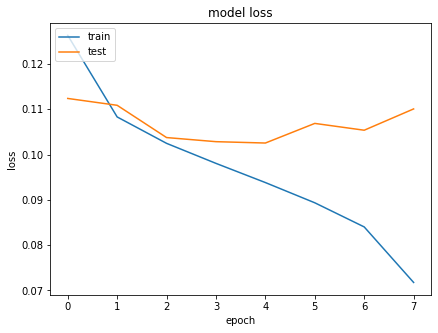

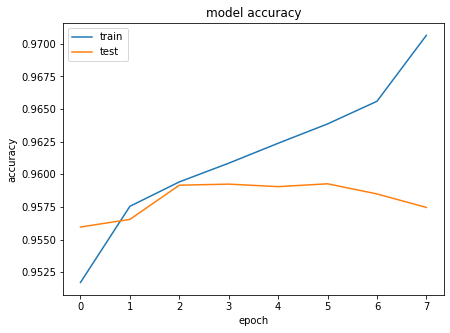

In [34]:
# summarize history for loss
plt.figure(figsize=(15, 5)).add_subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# summarize history for accuracy
plt.figure(figsize=(15, 5)).add_subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Có thể thấy được rằng mô hình hoạt động khá hiệu quả với tập **```train```** khi mà ```loss``` giảm đều và ```accuracy``` tăng đều qua các epoch<br>
Tuy nhiên thì với tập **```test```** lại hoạt động không được hiệu quả khi ```loss``` và ```accuracy``` có hình dạng trồi sụt nhìn như sóng biển. Và tệ hơn là với tập **```test```** thì ```loss``` về các epoch cuối lại tăng khá cao.

Lấy ra ```thresh_hold``` cho ```result``` tốt nhất và sử dụng nó để submit lên Kaggle

In [36]:
google_y_pre=google_model.predict(val_padded, verbose=1)
best_score = 0
best_thresh = 0
for thresh in np.arange(0.1,0.5,0.01):
    if(best_score < metrics.f1_score(val.target,(google_y_pre>thresh).astype(int))):
        best_score = metrics.f1_score(val.target,(google_y_pre>thresh))
        best_thresh = round(thresh, 2)
    print("threshold {0:2.2f} f1 score:{1:2.3f}".format(thresh,metrics.f1_score(val.target,(google_y_pre>thresh).astype(int))))
print("\033[1mBest result {0:2.3f} in thresh_hold {1:2.2f}\033[0m".format(best_score, best_thresh))

8164/8164 [==============================] - 66s 8ms/step
threshold 0.10 f1 score:0.577
threshold 0.11 f1 score:0.586
threshold 0.12 f1 score:0.595
threshold 0.13 f1 score:0.601
threshold 0.14 f1 score:0.608
threshold 0.15 f1 score:0.614
threshold 0.16 f1 score:0.620
threshold 0.17 f1 score:0.624
threshold 0.18 f1 score:0.629
threshold 0.19 f1 score:0.634
threshold 0.20 f1 score:0.637
threshold 0.21 f1 score:0.642
threshold 0.22 f1 score:0.644
threshold 0.23 f1 score:0.647
threshold 0.24 f1 score:0.650
threshold 0.25 f1 score:0.652
threshold 0.26 f1 score:0.654
threshold 0.27 f1 score:0.657
threshold 0.28 f1 score:0.658
threshold 0.29 f1 score:0.660
threshold 0.30 f1 score:0.662
threshold 0.31 f1 score:0.664
threshold 0.32 f1 score:0.666
threshold 0.33 f1 score:0.667
threshold 0.34 f1 score:0.668
threshold 0.35 f1 score:0.667
threshold 0.36 f1 score:0.667
threshold 0.37 f1 score:0.668
threshold 0.38 f1 score:0.668
threshold 0.39 f1 score:0.668
threshold 0.40 f1 score:0.668
threshold 0.

Như thầy có thể thấy thì kết quả tốt nhất loanh quanh ở ngưỡng xấp xỉ **```0.67```**<br>
Ta sẽ sử dụng ngưỡng **```0.67```** này để tham chiếu với các ma trận embeddings được xây dựng với 3 anh còn lại.

In [37]:
del model_embed, embedding_mat, history, best_score, best_thresh
gc.collect()

54311

# **6. So sánh, mở rộng**
Do sử dụng 1 pretrained là **Google News** nên kết quả thu được ở mức là **```0.67x``` (x<=3)** f1_score<br>
&nbsp;<br>
Bởi vì 3 thằng còn lại (không phải **Google News**) đều không ở dạng binary và không phải ở dạng chuẩn word_vector nên không đọc được bằng KeyedVectors, em sẽ định nghĩa một hàm để đọc các file embeddings còn lại <br>
Tuy nhiên do tự định nghĩa nên thời gian load dữ liệu vào biến khá là lâu

#### **Reference:** https://www.kaggle.com/theoviel/improve-your-score-with-some-text-preprocessing

Do có thằng ```wiki``` là ngoại đạo với đuôi là ```.vec``` nên cần định nghĩa riêng cho nó 1 ```statement```

In [38]:
def load_embed(file):
    def get_coefs(word,*arr):
        return word, np.asarray(arr, dtype='float32')

    if file == '../input/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec':
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file) if len(o)>100)
    else:
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file, encoding='latin'))

    return embeddings_index

In [39]:
!tree -h ./

./
├── [4.0K]  GoogleNews-vectors-negative300
│   └── [3.4G]  GoogleNews-vectors-negative300.bin
├── [ 263]  __notebook_source__.ipynb
├── [4.0K]  glove.840B.300d
│   └── [5.3G]  glove.840B.300d.txt
├── [4.0K]  paragram_300_sl999
│   ├── [ 731]  README.txt
│   └── [4.2G]  paragram_300_sl999.txt
└── [4.0K]  wiki-news-300d-1M
    └── [2.1G]  wiki-news-300d-1M.vec

4 directories, 6 files


In [40]:
glove_path = './glove.840B.300d/glove.840B.300d.txt'
paragram_path = './paragram_300_sl999/paragram_300_sl999.txt'
wiki_path = './wiki-news-300d-1M/wiki-news-300d-1M.vec'

Load các file embeddings vào biến<br>
Tuy nhiên do load thủ công không qua thư viện nên việc load khá là chậm, mất khoảng 9' để load cả 3 anh<br>
Bọn ```KeyedVector``` có hỗ trợ load ```glove``` nhưng phải covert qua binary nên về tốc độ thì cũng không hơn anh thủ công là mấy

In [41]:
%%time
glove_embed = load_embed(glove_path)
print("\033[1mGlove Coverage: \033[0m]")
oov_glove = check_voc(vocabulary2, glove_embed)

 21%|██        | 43110/208946 [00:00<00:00, 431035.67it/s]

Glove Coverage: ]


100%|██████████| 208946/208946 [00:00<00:00, 502078.50it/s]

The 60.72% of vocabularies have Covered of corpus
The 99.18% of total text had coverded 
CPU times: user 4min 7s, sys: 8.78 s, total: 4min 15s
Wall time: 4min 15s


Có thể dễ dàng nhận thấy anh **Google News** cho độ phủ không tốt bằng anh **Glove** khi anh **Glove** đạt độ phủ trên **99%** và **60.72%** với corpus qua đó có thể đoán được rằng ma trận embeddings của anh **Glove** sẽ giúp cho mô hình đạt được hiệu suất cao hơn

### **a. Glove**

In [42]:
strategy = None

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() # TPU detection
    strategy = tf.distribute.TPUStrategy(tpu)
    print('Use TPU')
except ValueError:
    if len(tf.config.list_physical_devices('GPU')) > 0:
        strategy = tf.distribute.MirroredStrategy()
        print('Use GPU')
    else:
        strategy = tf.distribute.get_strategy()
        print('Use CPU')

Use TPU


Lần đầu chạy không định nghĩa lại ```strategy.scope()``` thì em gặp một hiện tượng lạ đó là với việc build model mới và chạy trong ```strategy.scope()``` thì model có vẻ bị sai khá nhiều khi ```loss``` lên tới mức ```0.22``` với ```compile``` lần 1 và ```loss``` ở mức ```0.27``` với lần ```compile``` thứ 2<br>
Do vậy em đoán khả năng là do thằng ```strategy.scope()``` giữ lại một số giá trị gì đó nên em đã định nghĩa lại thằng ```strategy.scope()```

In [43]:
count=0
glove_embedding_mat=np.zeros((vocab_size,300))
for word,i in tqdm(word_index.items()):
    try:
        vec=glove_embed[word]
        glove_embedding_mat[i]=vec
    except KeyError:
        count+=1
        continue

print("Number of Out of Vocabulary",count)

100%|██████████| 208946/208946 [00:01<00:00, 132632.98it/s]

Number of Out of Vocabulary 82067


Có thể thấy được rằng số từ ```out_of_vocab``` giảm đi khá nhiều, ở mức 82067 từ, và qua đó có thể kỳ vọng mô hình đem lại độ chính xác cao hơn.<br>
Và em vẫn chưa có cách để xử lý những từ ```out_of_vocab``` như này 🥺🥺🥺

In [44]:
with strategy.scope():
    glove_model = get_model(glove_embedding_mat)
    glove_model.compile(loss=bin_loss, optimizer=Adam(lr=0.001), metrics=['accuracy'])
glove_history=glove_model.fit(train_padded, train.target, batch_size=BATCH_SIZE, epochs=30, validation_data=(val_padded, val.target),callbacks=my_callbacks)

Epoch 1/30
1021/1021 [==============================] - 35s 28ms/step - loss: 0.1390 - accuracy: 0.9504 - val_loss: 0.1052 - val_accuracy: 0.9580
Epoch 2/30
1021/1021 [==============================] - 25s 24ms/step - loss: 0.1021 - accuracy: 0.9594 - val_loss: 0.1011 - val_accuracy: 0.9598
Epoch 3/30
1021/1021 [==============================] - 25s 24ms/step - loss: 0.0949 - accuracy: 0.9621 - val_loss: 0.0996 - val_accuracy: 0.9606
Epoch 4/30
1021/1021 [==============================] - 25s 24ms/step - loss: 0.0892 - accuracy: 0.9640 - val_loss: 0.0996 - val_accuracy: 0.9602
Epoch 5/30
1021/1021 [==============================] - 24s 24ms/step - loss: 0.0819 - accuracy: 0.9661 - val_loss: 0.1012 - val_accuracy: 0.9608

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 6/30
1021/1021 [==============================] - 24s 24ms/step - loss: 0.0708 - accuracy: 0.9710 - val_loss: 0.1078 - val_accuracy: 0.9600


Khi truyền optimizer bằng biến ```opt``` cũ thì đã xảy ra lỗi và bắt buộc phải tự pass lại metrics mới vào trong ```model.compile()``` do đó em đã truyền vào optimizer là ```Adam``` với ```learning_rate``` bằng ```0.001``` giống ở trên để đảm bảo sự công bằng cho thử nghiệm

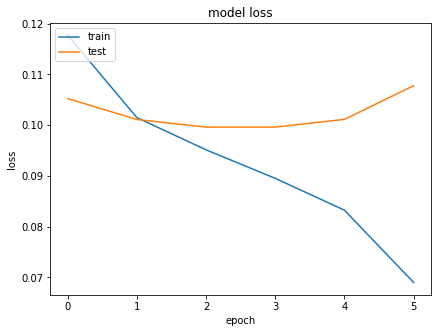

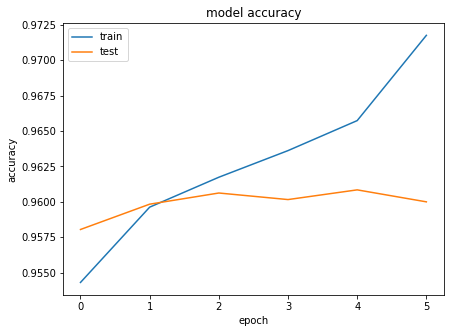

In [45]:
# summarize history for loss
plt.figure(figsize=(15, 5)).add_subplot(1, 2, 1)
plt.plot(glove_history.history['loss'])
plt.plot(glove_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# summarize history for accuracy
plt.figure(figsize=(15, 5)).add_subplot(1, 2, 2)
plt.plot(glove_history.history['accuracy'])
plt.plot(glove_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Khi sử dụng mô hình với ma trận embeddings sinh ra từ **Glove** thì nó cũng cho ra một kết quả khá giống với **Google News** khi mà **```train```** thì mô hình hoạt động khá hiệu quả <br>
Tuy nhiên cũng như **Google News** thì đối với tập test, càng về epoch cuối thì ```loss``` càng tăng cao, tuy nhiên có sự cải thiện hơn **Google News** khi mà ```accuracy``` có hình dạng ổn định hơn một chút.

In [46]:
glove_y_pre=glove_model.predict(val_padded, verbose=1)
best_score = 0
best_thresh = 0
for thresh in np.arange(0.1,0.5,0.01):
    if(best_score < metrics.f1_score(val.target,(glove_y_pre>thresh).astype(int))):
        best_score = metrics.f1_score(val.target,(glove_y_pre>thresh))
        best_thresh = round(thresh, 2)
    print("threshold {0:2.2f} f1 score:{1:2.3f}".format(thresh,metrics.f1_score(val.target,(glove_y_pre>thresh).astype(int))))
print("\033[1mBest result {0:2.3f} in thresh_hold {1:2.2f}\033[0m".format(best_score, best_thresh))

8164/8164 [==============================] - 67s 8ms/step
threshold 0.10 f1 score:0.628
threshold 0.11 f1 score:0.634
threshold 0.12 f1 score:0.640
threshold 0.13 f1 score:0.646
threshold 0.14 f1 score:0.651
threshold 0.15 f1 score:0.655
threshold 0.16 f1 score:0.659
threshold 0.17 f1 score:0.662
threshold 0.18 f1 score:0.664
threshold 0.19 f1 score:0.667
threshold 0.20 f1 score:0.669
threshold 0.21 f1 score:0.671
threshold 0.22 f1 score:0.672
threshold 0.23 f1 score:0.674
threshold 0.24 f1 score:0.676
threshold 0.25 f1 score:0.677
threshold 0.26 f1 score:0.678
threshold 0.27 f1 score:0.679
threshold 0.28 f1 score:0.679
threshold 0.29 f1 score:0.679
threshold 0.30 f1 score:0.679
threshold 0.31 f1 score:0.680
threshold 0.32 f1 score:0.679
threshold 0.33 f1 score:0.679
threshold 0.34 f1 score:0.679
threshold 0.35 f1 score:0.678
threshold 0.36 f1 score:0.678
threshold 0.37 f1 score:0.677
threshold 0.38 f1 score:0.677
threshold 0.39 f1 score:0.676
threshold 0.40 f1 score:0.674
threshold 0.

Rõ ràng khi sử dụng với file embeddings **Glove** thì kết quả đã có sự cải thiện rõ rệt với ```f1_score``` loanh quanh **```0.68```** tức **68%**<br>
Điều này có thể kết luận rằng số từ ```out_of_vocab``` và độ phủ của vocab thực sự ảnh hưởng tới hiệu năng của model.<br>

In [47]:
del glove_embed, glove_embedding_mat, glove_history, best_score, best_thresh
gc.collect()

43178

### **b. Paragram**

In [48]:
strategy = None

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() # TPU detection
    strategy = tf.distribute.TPUStrategy(tpu)
    print('Use TPU')
except ValueError:
    if len(tf.config.list_physical_devices('GPU')) > 0:
        strategy = tf.distribute.MirroredStrategy()
        print('Use GPU')
    else:
        strategy = tf.distribute.get_strategy()
        print('Use CPU')

Use TPU


In [49]:
%%time
paragram_embed = load_embed(paragram_path)
print("\033[1mParagram Coverage: \033[0m]")
oov_paragram = check_voc(vocabulary2, paragram_embed)

 29%|██▊       | 59969/208946 [00:00<00:00, 599636.25it/s]

Paragram Coverage: ]


100%|██████████| 208946/208946 [00:00<00:00, 619137.14it/s]

The 72.00% of vocabularies have Covered of corpus
The 99.46% of total text had coverded 
CPU times: user 3min 11s, sys: 3.98 s, total: 3min 15s
Wall time: 3min 15s


Có thể thấy rằng độ phủ của anh **Paragram** còn tốt hơn anh **Glove** khi đạt tới **99.46%** và độ phủ với ```corpus``` đạt tới **72%**.<br> Kì vọng là sẽ tạo ra ma trận embeddings giúp cho model có hiệu năng tốt nhất

In [50]:
count=0
para_embedding_mat=np.zeros((vocab_size,300))
for word,i in tqdm(word_index.items()):
    try:
        vec=paragram_embed[word]
        para_embedding_mat[i]=vec
    except KeyError:
        count+=1
        continue

print("Number of Out of Vocabulary",count)

100%|██████████| 208946/208946 [00:00<00:00, 213364.47it/s]

Number of Out of Vocabulary 58500


So với 2 file embeddings ở trên là **Google News** và **Glove** thì số lượng từ nằm ngoài tập vocab ```out_of_vocab``` giảm đi khá nhiều khi chỉ còn 58500 từ<br>
Và như trình bày ở trên thì **Paragram** cho độ phủ tốt nhất với **99.46%**.<br>
Có thể kỳ vọng với ma trận embeddings sinh ra từ **Paragram** thì mô hình sẽ đạt hiệu quả tốt nhất.

In [51]:
with strategy.scope():
    para_model = get_model(para_embedding_mat)
    para_model.compile(loss=bin_loss, optimizer=Adam(lr=0.001), metrics=['accuracy'])
para_history=para_model.fit(train_padded, train.target, batch_size=BATCH_SIZE, epochs=30, validation_data=(val_padded, val.target),callbacks=my_callbacks)

Epoch 1/30
1021/1021 [==============================] - 34s 27ms/step - loss: 0.1487 - accuracy: 0.9434 - val_loss: 0.1078 - val_accuracy: 0.9570
Epoch 2/30
1021/1021 [==============================] - 25s 24ms/step - loss: 0.1026 - accuracy: 0.9589 - val_loss: 0.1060 - val_accuracy: 0.9577
Epoch 3/30
1021/1021 [==============================] - 25s 24ms/step - loss: 0.0945 - accuracy: 0.9619 - val_loss: 0.1013 - val_accuracy: 0.9601
Epoch 4/30
1021/1021 [==============================] - 25s 24ms/step - loss: 0.0865 - accuracy: 0.9649 - val_loss: 0.1016 - val_accuracy: 0.9595
Epoch 5/30
1021/1021 [==============================] - 27s 26ms/step - loss: 0.0764 - accuracy: 0.9687 - val_loss: 0.1056 - val_accuracy: 0.9592

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 6/30
1021/1021 [==============================] - 25s 24ms/step - loss: 0.0601 - accuracy: 0.9756 - val_loss: 0.1217 - val_accuracy: 0.9590


Ở ```epoch``` cuối cùng thì đúng như dự đoán khi mà ```loss``` của mô hình đi kèm với ma trận embeddings của **Paragram** đạt được ```loss``` ở mức thấp nhất là ```0.5x``` (x học tiểu học) và đi kèm với đó là ```accuracy``` cao đạt mức ```0.9791```.<br>
Tuy nhiên điều quan trọng hơn đó chính là đánh giá hiệu năng của mô hình thông qua ```f1_score```

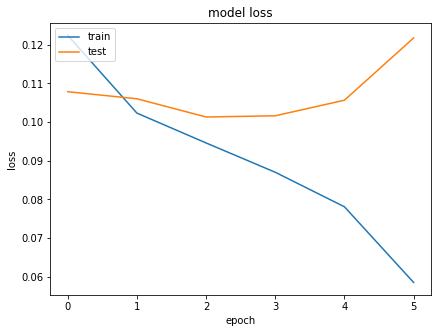

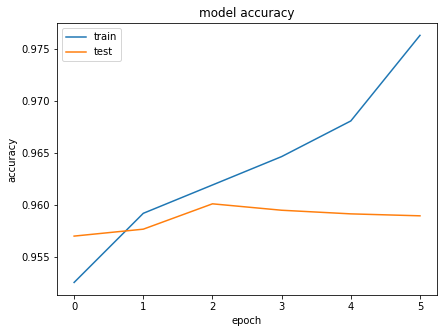

In [52]:
# summarize history for loss
plt.figure(figsize=(15, 5)).add_subplot(1, 2, 1)
plt.plot(para_history.history['loss'])
plt.plot(para_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# summarize history for accuracy
plt.figure(figsize=(15, 5)).add_subplot(1, 2, 2)
plt.plot(para_history.history['accuracy'])
plt.plot(para_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Cũng như 2 anh ở trên thì mô hình với ma trận embeddings của **Paragram** lại cho ```loss``` của tập **```test```** tăng dần về những epoch cuối.<br>
Có thể là do config của model không hiệu quả.

In [53]:
para_y_pre=para_model.predict(val_padded, verbose=1)
best_score = 0
best_thresh = 0
for thresh in np.arange(0.1,0.5,0.01):
    if(best_score < metrics.f1_score(val.target,(para_y_pre>thresh).astype(int))):
        best_score = metrics.f1_score(val.target,(para_y_pre>thresh))
        best_thresh = round(thresh, 2)
    print("threshold {0:2.2f} f1 score:{1:2.3f}".format(thresh,metrics.f1_score(val.target,(para_y_pre>thresh).astype(int))))
print("\033[1mBest result {0:2.3f} in thresh_hold {1:2.2f}\033[0m".format(best_score, best_thresh))

8164/8164 [==============================] - 68s 8ms/step
threshold 0.10 f1 score:0.616
threshold 0.11 f1 score:0.623
threshold 0.12 f1 score:0.630
threshold 0.13 f1 score:0.636
threshold 0.14 f1 score:0.640
threshold 0.15 f1 score:0.645
threshold 0.16 f1 score:0.649
threshold 0.17 f1 score:0.652
threshold 0.18 f1 score:0.656
threshold 0.19 f1 score:0.659
threshold 0.20 f1 score:0.661
threshold 0.21 f1 score:0.662
threshold 0.22 f1 score:0.665
threshold 0.23 f1 score:0.667
threshold 0.24 f1 score:0.669
threshold 0.25 f1 score:0.669
threshold 0.26 f1 score:0.670
threshold 0.27 f1 score:0.670
threshold 0.28 f1 score:0.671
threshold 0.29 f1 score:0.671
threshold 0.30 f1 score:0.672
threshold 0.31 f1 score:0.673
threshold 0.32 f1 score:0.672
threshold 0.33 f1 score:0.672
threshold 0.34 f1 score:0.671
threshold 0.35 f1 score:0.670
threshold 0.36 f1 score:0.669
threshold 0.37 f1 score:0.668
threshold 0.38 f1 score:0.667
threshold 0.39 f1 score:0.665
threshold 0.40 f1 score:0.664
threshold 0.

Qua nhiều lần thử nghiệm có thể thấy rằng anh **Paragram** cho hiệu năng không như kì vọng khi anh ấy đạt độ phủ tốt nhất, oov thấp nhất, tuy nhiên model khi train với ma trận embeddings của anh **Paragram** cho hiệu năng vẫn kém hơn anh **Glove**

In [54]:
del paragram_embed, para_embedding_mat, para_history, best_score, best_thresh
gc.collect()

43031

### **c. Wiki**

In [55]:
strategy = None

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() # TPU detection
    strategy = tf.distribute.TPUStrategy(tpu)
    print('Use TPU')
except ValueError:
    if len(tf.config.list_physical_devices('GPU')) > 0:
        strategy = tf.distribute.MirroredStrategy()
        print('Use GPU')
    else:
        strategy = tf.distribute.get_strategy()
        print('Use CPU')

Use TPU


In [56]:
%%time
wiki_embed = load_embed(wiki_path)
print("\033[1mWiki Coverage: \033[0m]")
oov_wiki = check_voc(vocabulary2, wiki_embed)

 26%|██▌       | 53720/208946 [00:00<00:00, 537135.20it/s]

Wiki Coverage: ]


100%|██████████| 208946/208946 [00:00<00:00, 578770.55it/s]

The 45.72% of vocabularies have Covered of corpus
The 97.84% of total text had coverded 
CPU times: user 1min 52s, sys: 2.03 s, total: 1min 54s
Wall time: 1min 54s


So với 2 anh **Glove** và **Paragram** thì độ phủ của anh **Wiki** thấp hơn một chút, tuy nhiên qua ví dụ của anh **Paragram** thì không nói trước được điều gì

In [57]:
count=0
wiki_embedding_mat=np.zeros((vocab_size,300))
for word,i in tqdm(word_index.items()):
    try:
        vec=wiki_embed[word]
        wiki_embedding_mat[i]=vec
    except KeyError:
        count+=1
        continue

print("Number of Out of Vocabulary",count)

100%|██████████| 208946/208946 [00:00<00:00, 254269.57it/s]

Number of Out of Vocabulary 113413


Số lượng từ của anh **Wiki** cũng ở mức khá cao khi gần tiệm cận với anh **Google News**, vậy có thể là ma trận embeddings sẽ có nhiều từ không tìm được và hiệu năng model cũng sẽ không tốt bằng anh **Glove**

In [58]:
with strategy.scope():
    wiki_model = get_model(wiki_embedding_mat)
    wiki_model.compile(loss=bin_loss, optimizer=Adam(lr=0.001), metrics=['accuracy'])
wiki_history=wiki_model.fit(train_padded, train.target, batch_size=BATCH_SIZE, epochs=30, validation_data=(val_padded, val.target),callbacks=my_callbacks)

Epoch 1/30
1021/1021 [==============================] - 35s 28ms/step - loss: 0.1508 - accuracy: 0.9488 - val_loss: 0.1130 - val_accuracy: 0.9554
Epoch 2/30
1021/1021 [==============================] - 25s 25ms/step - loss: 0.1088 - accuracy: 0.9569 - val_loss: 0.1117 - val_accuracy: 0.9566
Epoch 3/30
1021/1021 [==============================] - 25s 25ms/step - loss: 0.1035 - accuracy: 0.9590 - val_loss: 0.1042 - val_accuracy: 0.9586
Epoch 4/30
1021/1021 [==============================] - 25s 24ms/step - loss: 0.0984 - accuracy: 0.9609 - val_loss: 0.1017 - val_accuracy: 0.9596
Epoch 5/30
1021/1021 [==============================] - 25s 24ms/step - loss: 0.0949 - accuracy: 0.9619 - val_loss: 0.1008 - val_accuracy: 0.9598
Epoch 6/30
1021/1021 [==============================] - 24s 24ms/step - loss: 0.0916 - accuracy: 0.9631 - val_loss: 0.1020 - val_accuracy: 0.9601
Epoch 7/30
1021/1021 [==============================] - 25s 24ms/step - loss: 0.0883 - accuracy: 0.9642 - val_loss: 0.1021 -

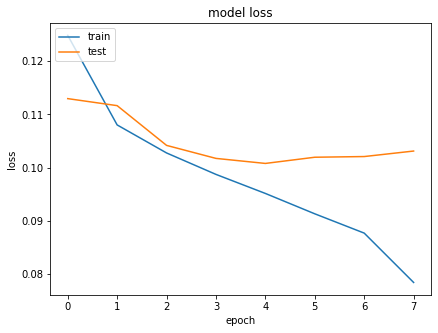

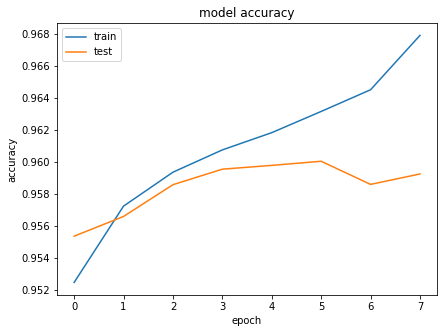

In [59]:
# summarize history for loss
plt.figure(figsize=(15, 5)).add_subplot(1, 2, 1)
plt.plot(wiki_history.history['loss'])
plt.plot(wiki_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# summarize history for accuracy
plt.figure(figsize=(15, 5)).add_subplot(1, 2, 2)
plt.plot(wiki_history.history['accuracy'])
plt.plot(wiki_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Cũng như 3 anh trên là **Glove**, **Paragram** và **Google News** thì anh **Wiki** này cũng có ```loss``` của tập test tăng dần về epoch cuối và ```accuracy``` không được cải thiện nhiều.<br>
Vậy nên ta cần phải config lại model, để đạt được hiệu quả cao hơn

In [60]:
wiki_y_pre=wiki_model.predict(val_padded, verbose=1)
best_score = 0
best_thresh = 0
for thresh in np.arange(0.1,0.5,0.01):
    if(best_score < metrics.f1_score(val.target,(wiki_y_pre>thresh).astype(int))):
        best_score = metrics.f1_score(val.target,(wiki_y_pre>thresh))
        best_thresh = round(thresh, 2)
    print("threshold {0:2.2f} f1 score:{1:2.3f}".format(thresh,metrics.f1_score(val.target,(wiki_y_pre>thresh).astype(int))))
print("\033[1mBest result {0:2.3f} in thresh_hold {1:2.2f}\033[0m".format(best_score, best_thresh))

8164/8164 [==============================] - 66s 8ms/step
threshold 0.10 f1 score:0.596
threshold 0.11 f1 score:0.603
threshold 0.12 f1 score:0.610
threshold 0.13 f1 score:0.616
threshold 0.14 f1 score:0.621
threshold 0.15 f1 score:0.626
threshold 0.16 f1 score:0.630
threshold 0.17 f1 score:0.635
threshold 0.18 f1 score:0.639
threshold 0.19 f1 score:0.643
threshold 0.20 f1 score:0.646
threshold 0.21 f1 score:0.650
threshold 0.22 f1 score:0.652
threshold 0.23 f1 score:0.655
threshold 0.24 f1 score:0.657
threshold 0.25 f1 score:0.659
threshold 0.26 f1 score:0.661
threshold 0.27 f1 score:0.663
threshold 0.28 f1 score:0.665
threshold 0.29 f1 score:0.666
threshold 0.30 f1 score:0.668
threshold 0.31 f1 score:0.669
threshold 0.32 f1 score:0.670
threshold 0.33 f1 score:0.670
threshold 0.34 f1 score:0.671
threshold 0.35 f1 score:0.672
threshold 0.36 f1 score:0.672
threshold 0.37 f1 score:0.673
threshold 0.38 f1 score:0.674
threshold 0.39 f1 score:0.674
threshold 0.40 f1 score:0.674
threshold 0.

Tuy độ phủ không đạt được như anh **Paragram** và số lượng từ ```out_of_vocab``` xấp xỉ anh **Google News** nhưng anh **Wiki** này cho hiệu năng rất đáng nể khi mà ma trận embeddings của anh này giúp model đạt ```f1_score``` xấp xỉ anh **Glove** tuy rằng **Glove** vẫn có phần nhỉnh hơn

In [61]:
del wiki_embed, wiki_embedding_mat, wiki_history, best_score, best_thresh
gc.collect()

43538

Oke vậy thì có thể thấy được rằng hiệu năng của model với các ma trận embeddings đến từ vị trí của 4 anh là **Google News**, **Glove**, **Paragram** và **Wiki** khá tương đồng với nhau, duy chỉ có anh **Google News** là thể hiện kém hơn 3 anh còn lại, cả về độ phủ, cả về ```f1_score``` và những yếu tố khác.<br>
Tuy nhiên chúng ta lại có thể thấy được rằng, với cả 4 model này tại sao lại không kếp hợp chúng vào với nhau để tạo ra một ```predict``` hiệu quả, thì dưới đây chính là sự kết hợp của cả 4 models<br>
Thuật ngữ chuyên ngành gọi là **Stack Models Prediction**<br>
Với **Stack Models Prediction** thì chúng ta có nhiều chiến lược, nhưng ở đây em sẽ nhân mỗi thằng ```predict``` với cùng một hệ số.<br>
Do có 4 thằng nên hệ số cho mỗi thằng là ```0.25``` và ta được một ```predict``` mới.<br>
Và việc ghép các **predicts** lại hoạt động khá hiệu quả khi ```f1_score``` của mô hình đạt tới **69%** tức ```0.69```

In [62]:
y_pre=0.25*(google_y_pre + glove_y_pre + para_y_pre + wiki_y_pre)
best_score = 0
best_thresh = 0
for thresh in np.arange(0.1,0.5,0.01):
    if(best_score < metrics.f1_score(val.target,(y_pre>thresh).astype(int))):
        best_score = metrics.f1_score(val.target,(y_pre>thresh))
        best_thresh = round(thresh, 2)
    print("threshold {0:2.2f} f1 score:{1:2.3f}".format(thresh,metrics.f1_score(val.target,(y_pre>thresh).astype(int))))
print("\033[1mBest result {0:2.3f} in thresh_hold {1:2.2f}\033[0m".format(best_score, best_thresh))

threshold 0.10 f1 score:0.606
threshold 0.11 f1 score:0.616
threshold 0.12 f1 score:0.624
threshold 0.13 f1 score:0.631
threshold 0.14 f1 score:0.638
threshold 0.15 f1 score:0.644
threshold 0.16 f1 score:0.649
threshold 0.17 f1 score:0.654
threshold 0.18 f1 score:0.659
threshold 0.19 f1 score:0.663
threshold 0.20 f1 score:0.667
threshold 0.21 f1 score:0.670
threshold 0.22 f1 score:0.673
threshold 0.23 f1 score:0.676
threshold 0.24 f1 score:0.678
threshold 0.25 f1 score:0.680
threshold 0.26 f1 score:0.682
threshold 0.27 f1 score:0.683
threshold 0.28 f1 score:0.685
threshold 0.29 f1 score:0.685
threshold 0.30 f1 score:0.686
threshold 0.31 f1 score:0.687
threshold 0.32 f1 score:0.688
threshold 0.33 f1 score:0.689
threshold 0.34 f1 score:0.689
threshold 0.35 f1 score:0.689
threshold 0.36 f1 score:0.690
threshold 0.37 f1 score:0.689
threshold 0.38 f1 score:0.688
threshold 0.39 f1 score:0.686
threshold 0.40 f1 score:0.685
threshold 0.41 f1 score:0.685
threshold 0.42 f1 score:0.684
threshold 